# FINM33150 Quant Trading Strategy
### Alexander Popat 12411234
### Joshua Weekes 12414910
### Taylor Wood 12414926

In [14]:
library(tidyverse)
library(readxl)
library(jsonlite)
library(Quandl)
Quandl.api_key("EsFRJz6Xd3CxmytxKgCB")
source("functions_data_retrieval.R")

Loading required package: xts

Loading required package: zoo


Attaching package: ‘zoo’


The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric



######################### Warning from 'xts' package ##########################
#                                                                             #
# The dplyr lag() function breaks how base R's lag() function is supposed to  #
# work, which breaks lag(my_xts). Calls to lag(my_xts) that you type or       #
# source() into this session won't work correctly.                            #
#                                                                             #
# Use stats::lag() to make sure you're not using dplyr::lag(), or you can add #
# conflictRules('dplyr', exclude = 'lag') to your .Rprofile to stop           #
# dplyr from breaking base R's lag() function.                                #
#                                                                             #
# Code in packages is n

## Introduction

The purpose of this strategy is to mimic the return and volatility profile of private credit funds using publicly traded Business Development Companies (BDCs). We look at the return profile of buying the BDC ETF BIZD, and buy protective option collars using options on other ETFs. The popularity and investor demand for Private Credit funds has grown tremendously over the past decade and direct lending funds have been able to raise over \$675 billion for direct lending strategies due to their relatively high returns and low volatility. While private credit is an attractive asset class for investors, private credit funds typically offer poor liquidity. Publicly traded BDCs offer similar credit exposure but with much higher liquidity due to the fact that they trade on exchanges. The additional liquidity offered by BDCs comes with higher volatility however, and look much less attractive on a risk-reward basis. By using options, we attempt to lower the volatility of a BDC investment strategy to match that of a private credit fund, while still generating similar returns. This strategy should be very attractive to current and potential private credit investors.

### The Rise of Private Credit Funds

Private credit as an asset class has attracted nearly $1 trillion in assets since the great financial crisis, as investors sought high yielding and diversifying assets. At the same time, increased financial regulation on banks required lenders to boost capital ratios, lowering their ability to make loans.

The chart below shows the cumulative capital raised in private credit funds since 2008, as measured by PitchBook. Investor demand has been especially strong despite high management and performance fees, as well as liquidity constraints. When investing in a private credit fund, capital is typically locked up for multiple years while the loans mature. On top of that, capital committed to a private credit fund is only deployed once loans are made, creating a lag between the time when an investor wants to gain exposure to private credit and when they actually do. Despite these drawbacks, investors are still willing to commit capital and pay high fees.

New names:
• `` -> `...1`


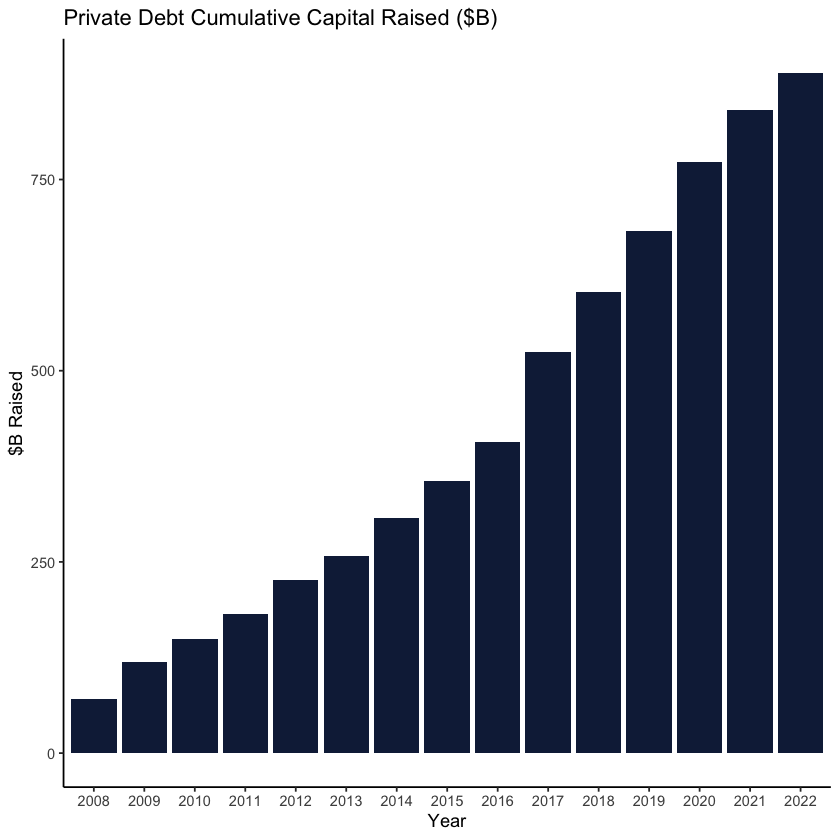

In [2]:
PD_capital_raise <- 
  readxl::read_excel(
    "PitchBook_Q3_2023_Global_Private_Market_Fundraising_Report_Summary_XLS - TW.xlsx", 
    sheet = "FoF fundraising", 
    skip = 5, 
    n_max = 2)

plot_PD_capital_raise <-
  PD_capital_raise %>%
  dplyr::rename(`metric` = `...1`) %>%
  tidyr::pivot_longer(cols = c(tidyselect::everything(), -`metric`), names_to = "year") %>%
  dplyr::filter(metric %in% "Capital raised ($B)") %>%
  dplyr::filter(!(year %in% "2023")) %>%
  ggplot() +
  aes(x = year, y = value) +
  geom_col(fill = "#112446") +
  labs(
      x = "Year",
      y = "$B Raised",
      title = "Private Debt Capital Raised ($B) by Year") +
  theme_classic()

plot_PD_capital_raise_cum <-
  PD_capital_raise %>%
  dplyr::rename(`metric` = `...1`) %>%
  tidyr::pivot_longer(cols = c(tidyselect::everything(), -`metric`), names_to = "year") %>%
  dplyr::filter(metric %in% "Capital raised ($B)") %>%
  dplyr::filter(!(year %in% "2023")) %>%
  dplyr::mutate(`value` = cumsum(`value`)) %>%
  ggplot() +
  aes(x = year, y = value) +
  geom_col(fill = "#112446") +
  labs(
      x = "Year",
      y = "$B Raised",
      title = "Private Debt Cumulative Capital Raised ($B)") +
  theme_classic()

plot_PD_capital_raise_cum

Private credit is especially attractive to investor as an asset class because of its high single digit returns and relatively low volatility. From Q3 2004 through Q3 2024, private debt has had an average annualized return of 9.4% and an average annualized standard deviation of 8.3%, as measured by the PitchBook Private Debt Index. The chart below shows the cumulative total return of the Pitchbook Private Debt Index over that time. While this is the reported volatility that investors receive in aggregate, it is likely understated given the ability for fund managers to chose how they mark their assets. 

New names:
• `` -> `...1`


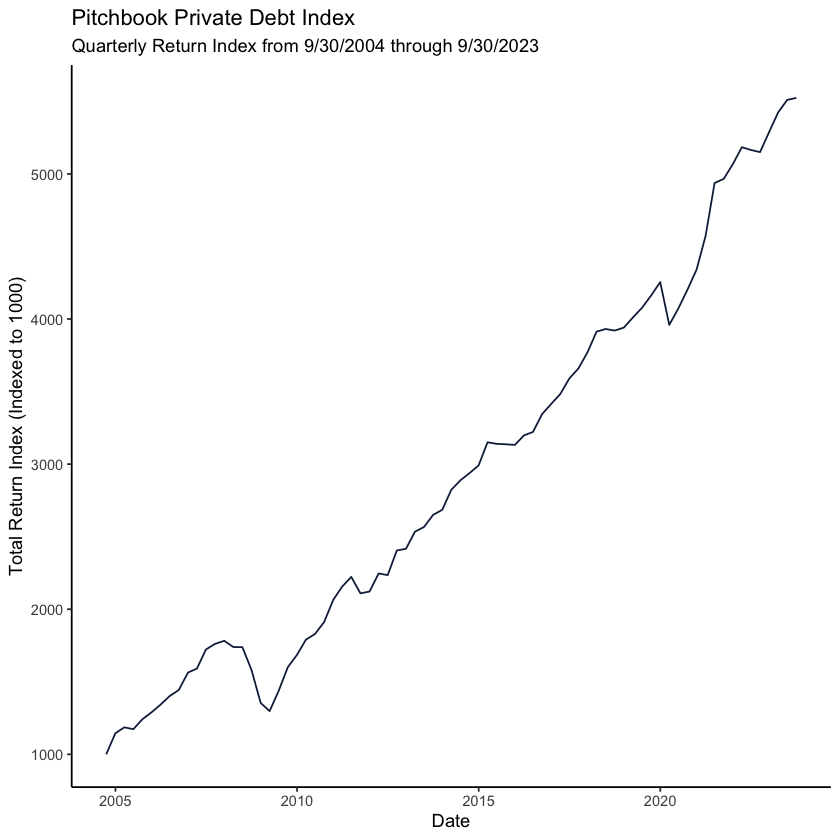

In [3]:
PD_returns <- 
  readxl::read_excel(
    "Q3_2023_PitchBook_Private_Capital_Indexes_Summary_XLS_15470.xlsx", 
    sheet = "Quarterly Returns", 
    skip = 5) %>%
  dplyr::rename(`date` = `...1`) %>%
  dplyr::mutate(`date` = as.Date(`date`)) %>%
  dplyr::select(`date`, `Private debt`) %>%
  dplyr::filter(`date` >= as.Date("2004-12-31"))

PD_ann_ret <- mean(PD_returns$`Private debt`) * 4
PD_ann_vol <- sd(PD_returns$`Private debt`) * sqrt(4)

plot_PD_index <-
  PD_returns %>%
  dplyr::mutate(`index` = cumprod(1 + `Private debt`)*1000, .keep = "unused") %>%
  dplyr::add_row(tibble::tibble_row(`date` = as.Date("2004-09-30"), `index` = 1000)) %>%
  ggplot() +
  aes(x = date, y = index) +
  geom_line(colour = "#112446") +
  labs(
    x = "Date",
    y = "Total Return Index (Indexed to 1000)",
    title = "Pitchbook Private Debt Index",
    subtitle = "Quarterly Return Index from 9/30/2004 through 9/30/2023") +
  theme_classic()

plot_PD_index

### Business Development Companies (BDCs)

Business Development Companies (BDCs) are closed end investment companies that make investments in primarily small to medium sized private companies. While BDCs can make investments across the capital structure, they tend to make first and second lien senor secured loans. In this way a BDC's investment portfolio is similar to that of a private credit fund. BDCs do not need to be publicly traded, but this analysis will only look at those that are.

BDCs are subject to certain regulatory and legal rules that impact their return profiles. As regulated investment companies (RIC), BDCs must deliver over 90% of their profits as dividends in order to avoid paying corporate tax on profits. BDCs are also limited to an asset coverage ratio of at least 200%, meaning they can leverage capital 1x.

In [11]:
# The following generates plots based on data obtained from BDCs.com
# Download CWBDC data from BDCs.com
CWBDC_data <- getCWBDCData()

# Plot the CWBDC price and total return indexes
plot_CWBDC_returns <-
  CWBDC_data %>%
  dplyr::select(`date`, `CWBDC`, `CWBDC_Price`) %>%
  dplyr::rename(
    `Total Return Index` = `CWBDC`,
    `Price Return Index` = `CWBDC_Price`) %>%
  tidyr::pivot_longer(cols = c(tidyselect::everything(), - `date`)) %>%
  ggplot() +
  aes(x = date, y = value, colour = name) +
  geom_line() +
  scale_color_hue(direction = 1) +
  labs(
    x = "Date",
    y = "Return Index Value (Starts at 1000)",
    title = "Cliffwater BDC Index: Total Return and Price Return Index",
    color = "Return Metric") +
  theme_classic()

# Plot the CWBDC dividend yield and 5 year treasury yield
plot_CWBDC_yield <-
  CWBDC_data %>%
  dplyr::select(`date`, `CWBDC_Yield`, `FiveYearTreasury`) %>%
  dplyr::rename(
    `CWBDC Index Dividend Yield` = `CWBDC_Yield`,
    `5 Year Treasury Yield` = `FiveYearTreasury`) %>%
  tidyr::pivot_longer(cols = c(tidyselect::everything(), -`date`)) %>%
  dplyr::mutate(`value` = `value` /100) %>%
  ggplot() +
  aes(x = date, y = value, colour = name) +
  geom_line() +
  scale_color_hue(direction = 1) +
  labs(
    x = "Date",
    y = "Yield",
    title = "CWBDC Index Dividend Yield and 5Yr Treasury Yield",
    color = "") +
  theme_classic()+
  scale_y_continuous(labels = scales::percent)

# Plot the volatility of NAV and Price
plot_CWBDC_vol <- 
  CWBDC_data %>%
  dplyr::select(`date`, `CWBDC_Price`, `CWBDC_NAV`, `CWBDC`) %>%
  dplyr::filter(`date` <= as.Date("2024-01-31")) %>%
  dplyr::group_by(`year` = lubridate::year(`date`), `month` = lubridate::month(`date`)) %>%
  dplyr::slice_tail(n=1) %>%
  dplyr::ungroup() %>%
  dplyr::select(-c(`year`, `month`)) %>%
  dplyr::mutate(
    `CWBDC Total Return` = `CWBDC` / lag(`CWBDC`, 1) - 1,
    `CWBDC Price Return` = `CWBDC_Price` / lag(`CWBDC_Price`, 1) - 1,
    `CWBDC Income Return` = (1+ `CWBDC Total Return`) / (1+`CWBDC Price Return`) -1,
    `CWBDC NAV Chg` = `CWBDC_NAV` / lag(`CWBDC_NAV`, 1) -1,
    .keep = "unused") %>%
  dplyr::summarise(
    `Total Return` = sd(`CWBDC Total Return`, na.rm = T) * sqrt(12),
    `Price` = sd(`CWBDC Price Return`, na.rm = T) * sqrt(12),
    `Dividend Return` = sd(`CWBDC Income Return`, na.rm = T) * sqrt(12),
    `NAV` = sd(`CWBDC NAV Chg`, na.rm = T) * sqrt(12)) %>%
  tidyr::pivot_longer(cols = tidyselect::everything()) %>%
  ggplot() +
  aes(x = `name`, y = `value`) +
  geom_col(fill = "#112446") +
  labs(
    y = "Annualized Volatility",
    x="",
    title = "Annualized Volatility") +
  theme_classic() +
  scale_y_continuous(labels = scales::percent)

plot_CWBDC_premdis_NAVchg <-
  CWBDC_data %>%
  dplyr::select(`date`, `PremDis`, `CWBDC_NAV`) %>%
  dplyr::filter(`date` <= as.Date("2024-01-31")) %>%
  dplyr::group_by(`year` = lubridate::year(`date`), `month` = lubridate::month(`date`)) %>%
  dplyr::slice_tail(n=1) %>%
  dplyr::ungroup() %>%
  dplyr::select(-c(`year`, `month`)) %>%
  dplyr::mutate(
    `Premium/Discount to NAV` = `PremDis` /100,
    `12M NAV Chg` = `CWBDC_NAV` / lag(`CWBDC_NAV`,12) - 1,
    .keep = "unused") %>%
  tidyr::pivot_longer(cols = c(tidyselect::everything(), -`date`)) %>%
  ggplot() +
  aes(x = date, y = value, colour = name) +
  geom_line() +
  scale_color_hue(direction = 1) +
  labs(
    x = "Date",
    y = "",
    color = "",
    title = "Premium/Discount to NAV and 12M Change in NAV") +
  theme_classic() +
  scale_y_continuous(labels = scales::percent) + theme(legend.position="top")


CWBDC_PD_return <-
  CWBDC_data %>%
  dplyr::select(`date`, `CWBDC_Price`, `CWBDC_Price_NAV`, `CWBDC`) %>%
  dplyr::filter(`date` <= as.Date("2024-01-31")) %>%
  dplyr::group_by(`year` = lubridate::year(`date`), `month` = lubridate::month(`date`)) %>%
  dplyr::slice_tail(n = 1) %>%
  dplyr::ungroup() %>%
  dplyr::select(-c(`year`, `month`)) %>%
  dplyr::mutate(
    `CWBDC Income` = `CWBDC` / `CWBDC_Price`,
    `CWBDC Income Return` = (`CWBDC Income`) / lag(`CWBDC Income`,1, default=1) -1,
    `CWBDC NAV Return` = `CWBDC_Price_NAV` / lag(`CWBDC_Price_NAV`, 1, default = 851.44) - 1,
    .keep = "unused") %>%
  dplyr::mutate(
    `CWBDC Income + NAV Index` = cumprod(1+ `CWBDC Income Return` + `CWBDC NAV Return`) * 1000) %>%
  dplyr::select(`date`, `CWBDC Income + NAV Index`) %>%
  dplyr::mutate(`date` = lubridate::ceiling_date(`date`, "month") -1) %>%
  left_join(
    PD_returns %>%
      dplyr::mutate(`Private Debt Index` = cumprod(1 + `Private debt`)*1000, .keep = "unused") %>%
      dplyr::add_row(tibble::tibble_row(`date` = as.Date("2004-09-30"), `Private Debt Index` = 1000)),
    by = "date")

plot_CWBDC_PD_return_comp <-
  CWBDC_PD_return %>%
  pivot_longer(cols = c(everything(), -`date`)) %>%
  filter(!is.na(value)) %>%
  ggplot() +
  aes(x = date, y = value, colour = name) +
  geom_line() +
  scale_color_hue(direction = 1) +
  labs(
    x = "Date",
    y = "Return Index Value (Starts at 1000)",
    title = "BDC Dividend + NAV Returns vs Private Debt Total Return",
    color = "") +
  theme_classic()

BDC returns are primarily driven by dividend income, since at least 90% of profits must be distributed to investors as dividends. BDC book value is therefore typically only negatively impacted from credit events, since profits can not be amassed as retained earnings. The chart below shows the price return and total return of the Cliffwater BDC Index (CWBDC) indexed to 1000 since September 30, 2004. Over the past nearly 2 decades, BDCs have returned over 340%, while prices have declined 42%.

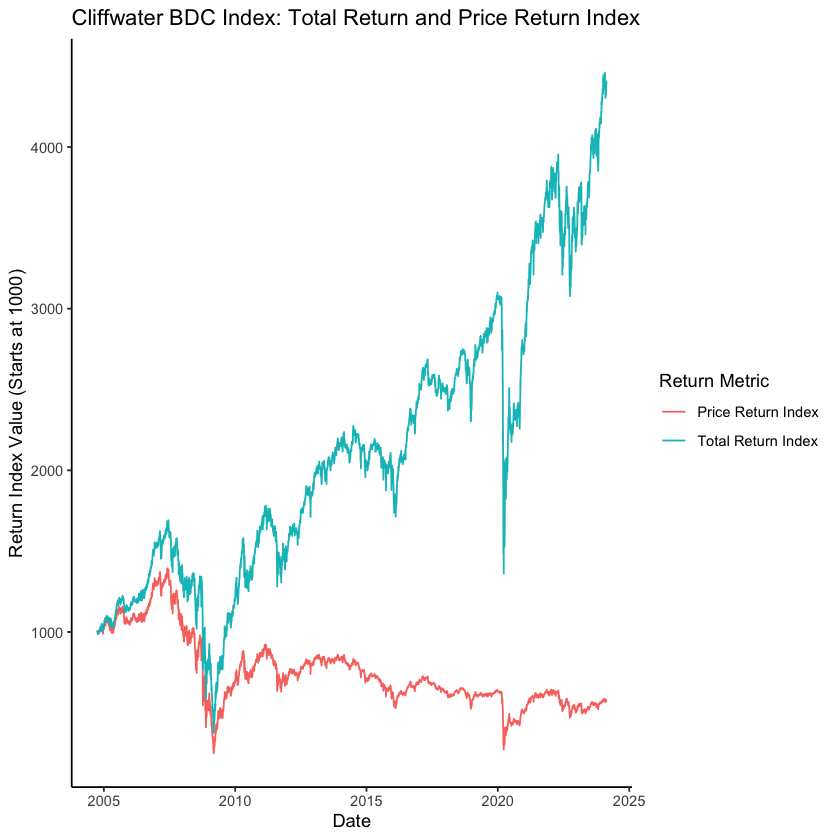

In [7]:
plot_CWBDC_returns

The chart below shows the trailing dividend yield of the Cliffwater BDC Index relative to the 5 Year Treasury Yield. The chart shows that since 2007, BDCs have had at least a high single digit dividend yield, similar to the return of private credit.

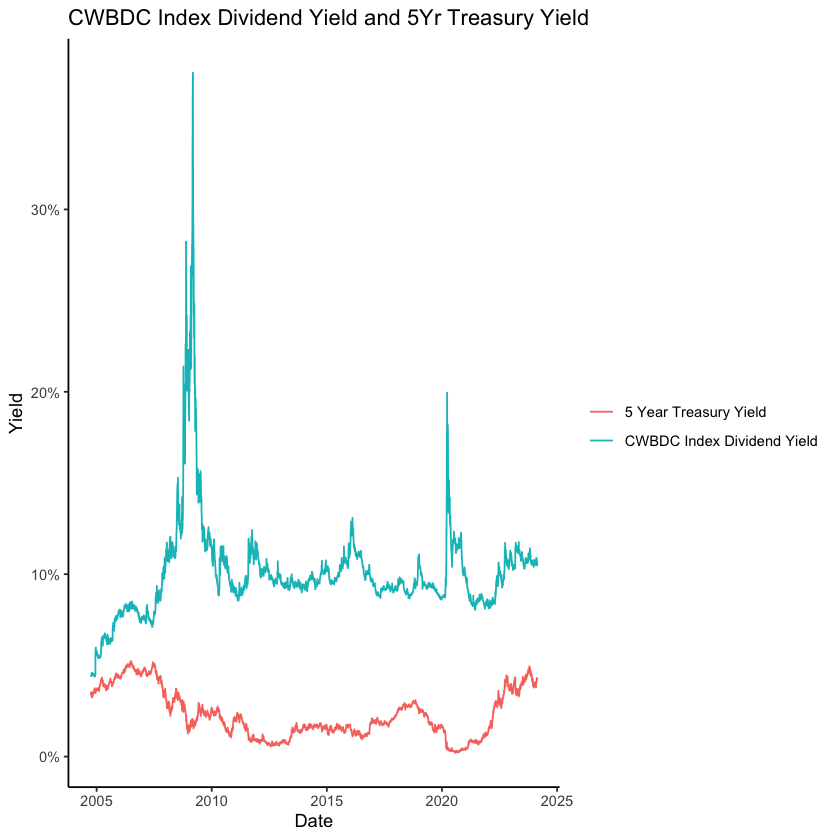

In [8]:
plot_CWBDC_yield

BDC volatility is primarily driven by changes in valuation, not the performance of their investment portfolios. The chart below shows the annualized standard deviation of the monthly dividend return, net asset value (NAV), price return and total return. Price return and total return volatility is very high at over 22%, while the volatility of the NAV is much lower at 6%, and dividend return is only 3.3%. This chart highlights that the changes in Price to NAV contribute a majority of the volatility to the total volatility profile of BDC returns.

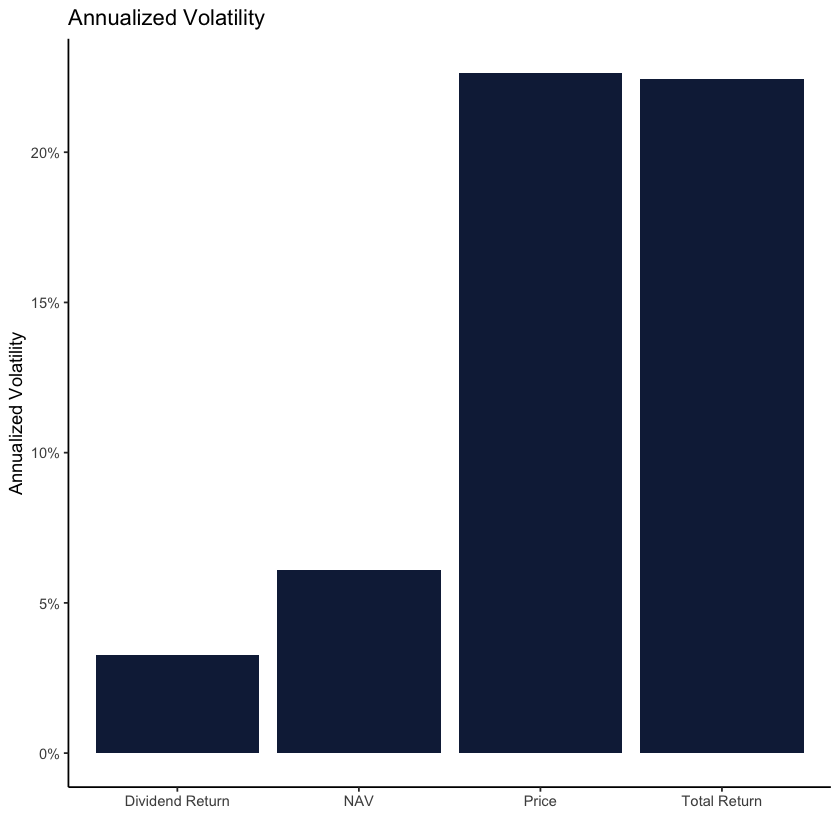

In [9]:
plot_CWBDC_vol

The change in valuation as measured by Price to NAV, which is driven by the expected changes in NAV, is typically directionally right but a much larger magnitude. The chart below shows the premium and discount to NAV of the CWBDC Index, and the 12 month change in NAV. The chart highlights the much higher volatility in Price to NAV vs the underlying volatility in NAV. For example, during the great financial crisis, the discount to NAV for BDCs reach a record low -60% (a price to NAV of merely 0.4x), while the actual NAV value decline by less than 20% on a trailing 12 month basis.

Warning message:
“Removed 12 rows containing missing values (`geom_line()`).”


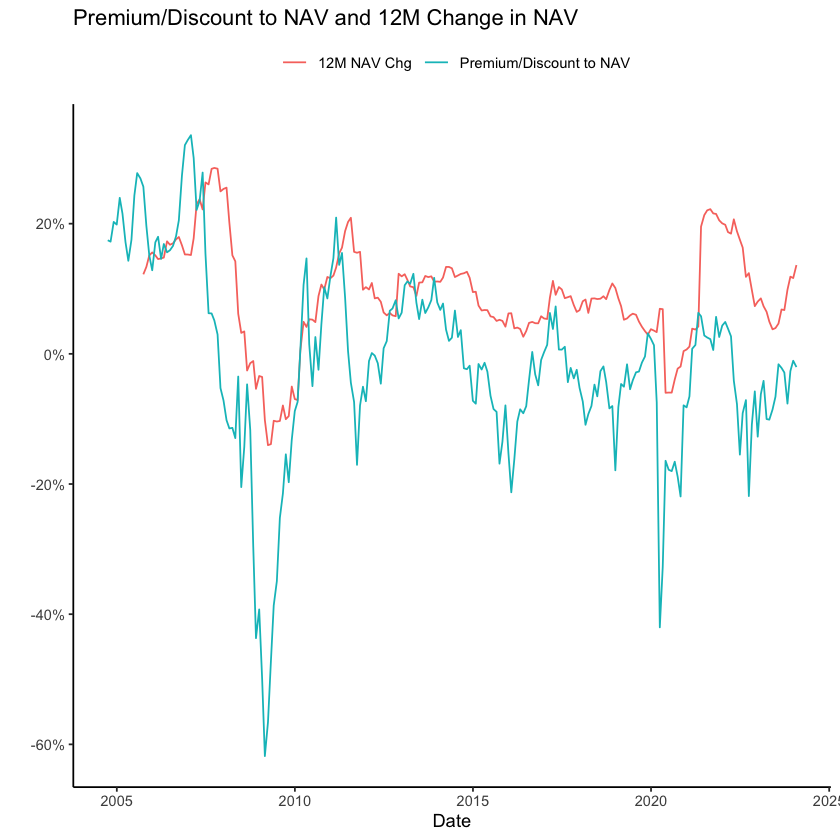

In [12]:
plot_CWBDC_premdis_NAVchg 

## The Strategy

Out strategy is to take advantage of investor's appetite for private credit exposure, but offer a liquid alternative using protective option collars on BDCs. Since BDCs are essentially publicly trade private credit vehicles, the economic exposure should be similar. Using option collars we can target the volatility levels of returns to try to match the volatility of private credit as an asset class.

For the strategy we will buy the VanEck BDC Income ETF (BIZD) to gain BDC exposure. The optimal strategy would be to build option collars using BIZD or other BDC options, but there are two reasons why we can not. First, options on BDCs are very illiquid. This can cause high bid ask spreads, making the collar prohibitively expensive. Secondly, since BDCs pay a large dividend, out of the money (OTM) call options with expiry post a dividend ex-date are likely to not generate much profit from selling, and put options with expiry post a dividend ex-date are likely to be very expensive.

Due to the lack of volume in BDC and BDC ETF options, we are forced to build the option collars using options on other ETFs that have more liquidity. We opted to use options on HYG, XLF, and IWM. Since we are cross hedging with other assets, we need to first calculate the optimal hedging ratio for each ETF that minimizes our basis risk. 

### Static In-Sample Optimal Hedge Example
The example below is a proof of concept for finding the optimal hedge using OLS regression on all the in-sample data. Regressing the returns of HYG, XLF, and IWM on BIZD, we can use the regression coefficients as our hedge ratios. The regression results below show that over the entire in sample time period from 12/31/2017 through 12/31/2023, the optimal hedge was to use 29% exposure to XLF, 38% exposure to IWM, and 89% exposure to HYG. The R-squared shows that this weighting scheme would hedge 70% of the weekly return volatility in BIZD.

In [16]:
BIZD <- 
  Quandl.datatable('QUOTEMEDIA/PRICES', ticker = "BIZD") %>%
  dplyr::arrange(`date`) %>%
  dplyr::select(`date`, `adj_close`) %>%
  dplyr::rename(`BIZD` = `adj_close`)

HYG <- 
  Quandl.datatable('QUOTEMEDIA/PRICES', ticker = "HYG") %>%
  dplyr::arrange(`date`) %>%
  dplyr::select(`date`, `adj_close`) %>%
  dplyr::rename(`HYG` = `adj_close`)
  

XLF <- 
  Quandl.datatable('QUOTEMEDIA/PRICES', ticker = "XLF") %>%
  dplyr::arrange(`date`) %>%
  dplyr::select(`date`, `adj_close`) %>%
  dplyr::rename(`XLF` = `adj_close`)


IWM <- 
  Quandl.datatable('QUOTEMEDIA/PRICES', ticker = "IWM") %>%
  dplyr::arrange(`date`) %>%
  dplyr::select(`date`, `adj_close`) %>%
  dplyr::rename(`IWM` = `adj_close`)


ETF_Returns <- 
  BIZD %>%
  dplyr::inner_join(HYG, by = "date") %>%
  dplyr::inner_join(XLF, by = "date") %>%
  dplyr::inner_join(IWM,by = "date") %>%
  dplyr::filter(weekdays(`date`) == "Wednesday") %>%
  dplyr::mutate(
    `BIZD` = `BIZD` / lag(`BIZD`, 1) - 1,
    `HYG` = `HYG` / lag(`HYG`, 1) - 1,
    `XLF` = `XLF` / lag(`XLF`, 1) - 1,
    `IWM` = `IWM` / lag(`IWM`, 1) -1,
    .keep = "unused") %>%
  dplyr::slice(-1) %>%
  dplyr::filter(`date` >= as.Date("2017-12-31")) %>%
  dplyr::filter(`date` <= as.Date("2023-12-31"))

hedge_ols <- lm(BIZD ~  XLF + IWM + HYG, data = ETF_Returns)

summary(hedge_ols)


Call:
lm(formula = BIZD ~ XLF + IWM + HYG, data = ETF_Returns)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.187772 -0.009148  0.000076  0.008840  0.072799 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 0.0007112  0.0011355   0.626    0.532    
XLF         0.2764284  0.0671083   4.119 4.90e-05 ***
IWM         0.3945066  0.0673051   5.861 1.19e-08 ***
HYG         0.8864663  0.1333468   6.648 1.37e-10 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.01993 on 305 degrees of freedom
Multiple R-squared:  0.7117,	Adjusted R-squared:  0.7089 
F-statistic:   251 on 3 and 305 DF,  p-value: < 2.2e-16
